Mounted at /content/drive


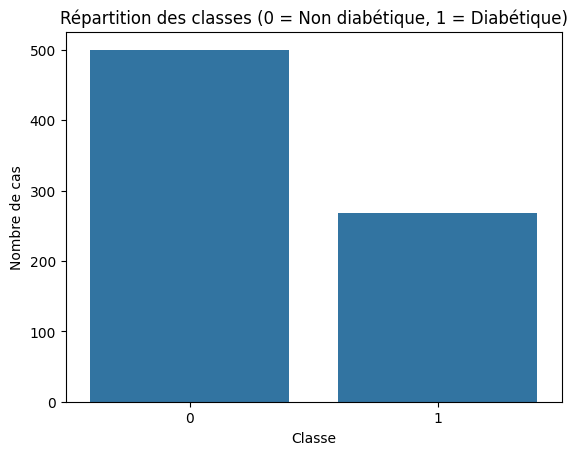


Statistiques descriptives par classe:
         Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
Outcome                                                                      
0           3.298000  110.682000      70.920000      27.726000  127.792000   
1           4.865672  142.130597      75.123134      31.686567  164.701493   

               BMI  DiabetesPedigreeFunction        Age  
Outcome                                                  
0        30.885600                  0.429734  31.190000  
1        35.383582                  0.550500  37.067164  

Features sélectionnées : ['Pregnancies', 'Glucose', 'SkinThickness', 'Insulin', 'BMI', 'Age']

[Modèle Logistique - Validation set]
Accuracy : 0.7922077922077922
Precision: 0.7837837837837838
Recall   : 0.5471698113207547
F1 Score : 0.6444444444444445
Epoch 10/50, Train Loss: 0.5186, Val Loss: 0.5396
Epoch 20/50, Train Loss: 0.6073, Val Loss: 0.4600
Epoch 30/50, Train Loss: 0.4714, Val Loss: 0.4546
Epoch 40/50, 

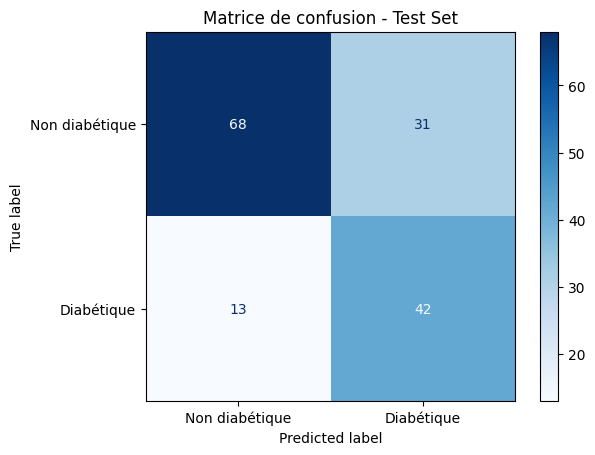


[Analyse Test Set - Modèle PyTorch]
Accuracy : 0.7142857142857143
Precision: 0.5753424657534246
Recall   : 0.7636363636363637
F1 Score : 0.65625

[Importance des variables - Modèle Logistique]
Pregnancies : 0.2014
Glucose : 0.9354
SkinThickness : 0.1316
Insulin : -0.0455
BMI : 0.5519
Age : 0.4471

Faux positifs : 31 cas
Faux négatifs : 13 cas

Exemples de faux positifs :
   Pregnancies   Glucose  SkinThickness   Insulin       BMI       Age
0     0.639947 -0.777694       0.442995  0.571411  0.224838  0.830381
1     0.936914  0.471547      -0.012301 -0.181541 -0.371899  1.425995
2     0.639947 -0.613320       0.329171  0.571411  0.763356  1.851434
3    -1.141852 -0.153073      -0.012301 -0.181541  0.195728  0.915469
4     0.046014  1.063293      -0.012301 -0.169957 -0.168135  0.319855

Exemples de faux négatifs :
   Pregnancies   Glucose  SkinThickness   Insulin       BMI       Age
0     1.827813 -0.350322      -0.239949 -0.181541 -0.721209  0.575118
1    -0.844885  0.109925       1.239

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression




# Chargement des données

df = pd.read_csv("/content/drive/MyDrive/ML/diabetes.csv")


# Nettoyage des données

# Colonnes dans lesquelles les 0 sont invalides et doivent être traités comme des valeurs manquantes
cols_with_zero_invalid = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Remplacement des 0 par NaN (valeurs manquantes)
df[cols_with_zero_invalid] = df[cols_with_zero_invalid].replace(0, np.nan)

# Remplissage des NaN avec la médiane de chaque colonne (évitant inplace pour compatibilité future)
for col in cols_with_zero_invalid:
    median_value = df[col].median()
    df[col] = df[col].fillna(median_value)



# Analyse exploratoire (EDA)

# Barplot du déséquilibre de classes
sns.countplot(x='Outcome', data=df)
plt.title("Répartition des classes (0 = Non diabétique, 1 = Diabétique)")
plt.xlabel("Classe")
plt.ylabel("Nombre de cas")
plt.show()

# Statistiques descriptives par classe
print("\nStatistiques descriptives par classe:")
print(df.groupby("Outcome").mean())


# Préparation des données

X = df.drop("Outcome", axis=1)
y = df["Outcome"].values

selector = SelectKBest(score_func=f_classif, k=6)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("\nFeatures sélectionnées :", list(selected_features))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


# Logistic Regression - Modélisation de base pour comparaison

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_val_pred_lr = logreg.predict(X_val)

print("\n[Modèle Logistique - Validation set]")
print("Accuracy :", accuracy_score(y_val, y_val_pred_lr))
print("Precision:", precision_score(y_val, y_val_pred_lr))
print("Recall   :", recall_score(y_val, y_val_pred_lr))
print("F1 Score :", f1_score(y_val, y_val_pred_lr))


# Gestion du déséquilibre avec WeightedRandomSampler

class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
weight = 1. / class_sample_count
target_weights = weight[y_train]

sampler = WeightedRandomSampler(weights=target_weights, num_samples=len(target_weights), replacement=True)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32)


# Définition du modèle PyTorch

class DiabeteModel(nn.Module):
    def __init__(self):
        super(DiabeteModel, self).__init__()
        self.fc1 = nn.Linear(6, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


# Entraînement du modèle

model = DiabeteModel()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 50
for epoch in range(epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")


# Évaluation finale sur le test set

model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_labels = (y_pred >= 0.5).float()
    acc = accuracy_score(y_test_tensor.numpy(), y_pred_labels.numpy())
    print(f"\nPrécision finale sur le jeu de test : {acc*100:.2f}%")

    # Matrice de confusion et métriques
    cm = confusion_matrix(y_test_tensor.numpy(), y_pred_labels.numpy())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non diabétique", "Diabétique"])
    disp.plot(cmap="Blues")
    plt.title("Matrice de confusion - Test Set")
    plt.show()

    print("\n[Analyse Test Set - Modèle PyTorch]")
    print("Accuracy :", accuracy_score(y_test_tensor.numpy(), y_pred_labels.numpy()))
    print("Precision:", precision_score(y_test_tensor.numpy(), y_pred_labels.numpy()))
    print("Recall   :", recall_score(y_test_tensor.numpy(), y_pred_labels.numpy()))
    print("F1 Score :", f1_score(y_test_tensor.numpy(), y_pred_labels.numpy()))



    # Explainability: Importance des variables + analyse des erreurs


    # Importance des features (modèle logistique comme baseline interprétable)
    print("\n[Importance des variables - Modèle Logistique]")
    for name, coef in zip(selected_features, logreg.coef_[0]):
        print(f"{name} : {coef:.4f}")

    # Analyse des erreurs : faux positifs / faux négatifs
    y_test_np = y_test_tensor.numpy().flatten()
    y_pred_np = y_pred_labels.numpy().flatten()

    false_positives = np.where((y_test_np == 0) & (y_pred_np == 1))[0]
    false_negatives = np.where((y_test_np == 1) & (y_pred_np == 0))[0]

    print(f"\nFaux positifs : {len(false_positives)} cas")
    print(f"Faux négatifs : {len(false_negatives)} cas")

    # Affichage de quelques exemples
    print("\nExemples de faux positifs :")
    print(pd.DataFrame(X_test[false_positives][:5], columns=selected_features))

    print("\nExemples de faux négatifs :")
    print(pd.DataFrame(X_test[false_negatives][:5], columns=selected_features))





